# Advanced Machine Learning - Exercise 5
Dominique Cheray & Manuel Krämer

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol
import GPy
import optunity
from scipy import stats
from ridge_regression import kernel_ridge_regression

## 1 GP Optimization of a Toy Problem

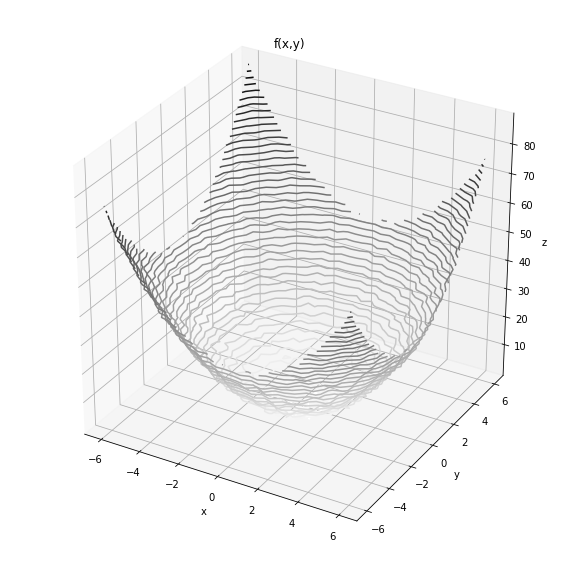

In [2]:
# 1. implement f(x, y) and plot it
def f(x, y):
    return x**2-x+y**2+y-np.cos((2*np.pi*x-np.pi))-np.cos((2*np.pi*y+np.pi))+2.5


xs = np.linspace(-6, 6, 30)
ys = np.linspace(-6, 6, 30)
X, Y = np.meshgrid(xs, ys)
Z = f(X, Y)
fig = plt.figure(figsize=((10, 10)))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('f(x,y)')
plt.show()

In [3]:
# 3. + 4.  create initial training set
number_of_samples = 30
parameterUpperLimits = np.array([6, 6])
parameterLowerLimits = np.array([-6, -6])
Q = np.zeros((number_of_samples, 2))
E = np.zeros((number_of_samples, 1))
for i in range(number_of_samples):
    x, y = sobol.i4_sobol(2, i)[0] * (parameterUpperLimits - parameterLowerLimits) + parameterLowerLimits
    Q[i] = [x, y]
    E[i] = [f(x, y)]

In [4]:
# 5. train GP model
model = GPy.models.GPRegression(Q, E, GPy.kern.RBF(2)+GPy.kern.White(2))
model.optimize()

In [5]:
# 2. utility function
def u(x, y):
    E_best = np.min(E)
    mean, var = model.predict(np.array([[x, y]]))
    gamma_q = (E_best - mean[0, 0]) / np.sqrt(var[0, 0])
    return np.sqrt(var[0, 0]) * (gamma_q * stats.norm.cdf(gamma_q) + stats.norm.pdf(gamma_q))

In [6]:
# 2. utility function
def u(x, y):
    E_best = np.min(E)
    mean, var = model.predict(np.array([[x, y]]))
    gamma_q = (E_best - mean[0, 0]) / np.sqrt(var[0, 0])
    return np.sqrt(var[0, 0]) * (gamma_q * stats.norm.cdf(gamma_q) + stats.norm.pdf(gamma_q))

In [7]:
# 6. + 7. + 8. optimize, evaluate, repeat
for i in range(30):
    q, details, _ = optunity.maximize(u, num_evals=100, x=[-6, 6], y=[-6, 6], solver_name='particle swarm')
    e = f(q['x'], q['y'])
    print("Iteration {}; x={:.4f}, y={:.4f}; True function value: {:.4f}; Predicted function value:{:.4f}".format((i+1), q['x'], q['y'], e, model.posterior_samples(np.array([[q['x'], q['y']]]), size=1)[0][0]))
    Q_new = np.zeros(((Q.shape[0] + 1), 2))
    E_new = np.zeros(((E.shape[0] + 1), 1))
    e = f(q['x'], q['y'])
    Q_new[range(Q.shape[0])] = Q
    Q_new[-1] = np.array([q['x'], q['y']])
    Q = Q_new
    E_new[range(E.shape[0])] = E
    E_new[-1] = [e]
    E = E_new
    model.set_XY(Q, E)
    model.optimize()

Iteration 1; x=0.3526, y=-0.6459; True function value: 0.8337; Predicted function value:2.9362
Iteration 2; x=0.2210, y=-0.7109; True function value: 2.0603; Predicted function value:1.0806


 /usr/local/lib/python3.5/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Iteration 3; x=0.4638, y=-0.6171; True function value: 0.2996; Predicted function value:1.1584
Iteration 4; x=0.3650, y=-0.7287; True function value: 1.2756; Predicted function value:4.7462
Iteration 5; x=0.2405, y=-0.6513; True function value: 1.5688; Predicted function value:2.1586
Iteration 6; x=0.3213, y=-0.8037; True function value: 2.0217; Predicted function value:1.1974
Iteration 7; x=0.3595, y=-0.5987; True function value: 0.5806; Predicted function value:0.6394
Iteration 8; x=0.4401, y=-0.6454; True function value: 0.4835; Predicted function value:2.3215
Iteration 9; x=0.4610, y=-0.5152; True function value: 0.0362; Predicted function value:1.6853
Iteration 10; x=0.3180, y=-0.5166; True function value: 0.6244; Predicted function value:2.0472
Iteration 11; x=0.5855, y=-0.5823; True function value: 0.2856; Predicted function value:0.3261
Iteration 12; x=0.3762, y=-0.6908; True function value: 0.9762; Predicted function value:1.6984
Iteration 13; x=0.3797, y=-0.5245; True functio

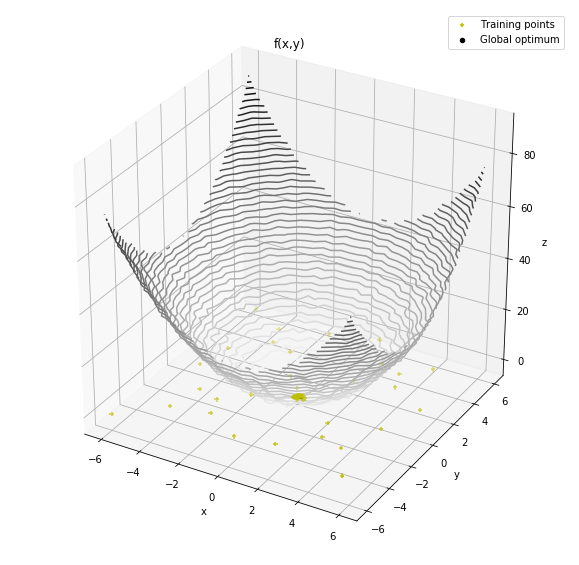

In [9]:
# 9. plot f(x,y), Q and global optimum
xs = np.linspace(-6, 6, 30)
ys = np.linspace(-6, 6, 30)
X, Y = np.meshgrid(xs, ys)
Z = f(X, Y)
fig = plt.figure(figsize=((10, 10)))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(Q[:, 0], Q[:, 1], marker='+', c='y', label='Training points')
ax.scatter(Q[np.argmin(E), 0], Q[np.argmin(E), 1], marker='o', c='k', label='Global optimum')
plt.legend()
plt.title('f(x,y)')
plt.show()

All training points are about on the same level as the minimum of the function and most of them clutter around the minimum of the function. One can hardly see the the global optimum since it is hidden underneath the training points cluttering around the minimum of f(x,y).

Iteration 1; x=0.3782, y=-0.6729; True function value: 0.8580; Predicted function value:1.1440
Iteration 2; x=-5.7959, y=5.8779; True function value: 83.3193; Predicted function value:78.5396


 /usr/local/lib/python3.5/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Iteration 3; x=0.3070, y=-0.4742; True function value: 0.7007; Predicted function value:0.7231
Iteration 4; x=-5.8748, y=5.6222; True function value: 80.1065; Predicted function value:78.5288
Iteration 5; x=0.5357, y=-0.3517; True function value: 0.4520; Predicted function value:2.6037
Iteration 6; x=-5.4682, y=4.4168; True function value: 59.9479; Predicted function value:62.2862
Iteration 7; x=0.5220, y=-0.5693; True function value: 0.1081; Predicted function value:0.6990
Iteration 8; x=-5.6728, y=5.8000; True function value: 79.6366; Predicted function value:80.7222
Iteration 9; x=0.4950, y=-0.3922; True function value: 0.2331; Predicted function value:2.2727
Iteration 10; x=-5.4450, y=5.9524; True function value: 78.9912; Predicted function value:78.4754
Iteration 11; x=0.4368, y=-0.6364; True function value: 0.4456; Predicted function value:2.5125
Iteration 12; x=-5.5910, y=5.8067; True function value: 78.3830; Predicted function value:75.7295
Iteration 13; x=0.2375, y=-0.5499; Tr

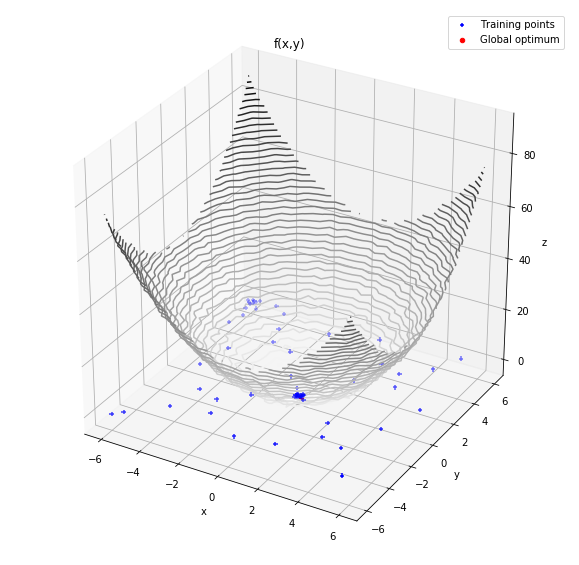

In [12]:
# 10. Repeat optimizing but alternate between utility functions
Q = np.zeros((number_of_samples, 2))
E = np.zeros((number_of_samples, 1))
for i in range(number_of_samples):
    x, y = sobol.i4_sobol(2, i)[0] * (parameterUpperLimits - parameterLowerLimits) + parameterLowerLimits
    Q[i] = [x, y]
    E[i] = [f(x, y)]

model = GPy.models.GPRegression(Q, E, GPy.kern.RBF(2)+GPy.kern.White(2))
model.optimize()

# save the inital 30 points for the plotting later
Q_30 = Q
E_30 = E

# function to optimize on the maximal variance of the GP model
def max_var(x, y):
    mean, var = model.predict(np.array([[x, y]]))
    return mean[0, 0]


for i in range(30):
    if i % 2 == 0:
        q, details, _ = optunity.maximize(u, num_evals=100, x=[-6, 6], y=[-6, 6], solver_name='particle swarm')
    else:
        q, details, _ = optunity.maximize(max_var, num_evals=100, x=[-6, 6], y=[-6, 6], solver_name='particle swarm')
    e = f(q['x'], q['y'])
    print("Iteration {}; x={:.4f}, y={:.4f}; True function value: {:.4f}; Predicted function value:{:.4f}".format((i+1), q['x'], q['y'], e, model.posterior_samples(np.array([[q['x'], q['y']]]), size=1)[0][0]))
    Q_new = np.zeros(((Q.shape[0] + 1), 2))
    E_new = np.zeros(((E.shape[0] + 1), 1))
    e = f(q['x'], q['y'])
    Q_new[range(Q.shape[0])] = Q
    Q_new[-1] = np.array([q['x'], q['y']])
    Q = Q_new
    E_new[range(E.shape[0])] = E
    E_new[-1] = [e]
    E = E_new
    model.set_XY(Q, E)
    model.optimize()

# again plot f(x,y), Q and global optimum 
xs = np.linspace(-6, 6, 30)
ys = np.linspace(-6, 6, 30)
X, Y = np.meshgrid(xs, ys)
Z = f(X, Y)
fig = plt.figure(figsize=((10, 10)))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(Q[:, 0], Q[:, 1], marker='+', c='b', label='Training points')
ax.scatter(Q[np.argmin(E), 0], Q[np.argmin(E), 1], marker='o', c='r', label='Global optimum')
plt.title('f(x,y)')
plt.legend()
plt.show()

Again most of the points clutter araound the minimum of the function but there are also more points at the edges of the sampling intervall. Probably those points were found by maximizing the variance of the GP model.

In [14]:
# sample 60 random uniform points and caculate f(x,y) for them
uniform_rand_points = np.random.uniform(-6, 6, (60,2))
E_uniform_rand_points = f(uniform_rand_points[:, 0], uniform_rand_points[:, 1])
print("Min of uniformly random points: {} Min of optimized points: {}".format(np.min(E_uniform_rand_points), np.min(E)))

Min of uniformly random points: 1.925463324407702 Min of optimized points: 0.046289452186895286


The minimum found by 60 uniform random points is far off from the minumum found by the optimization.

 /usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'linewidth', 'label'
 /usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


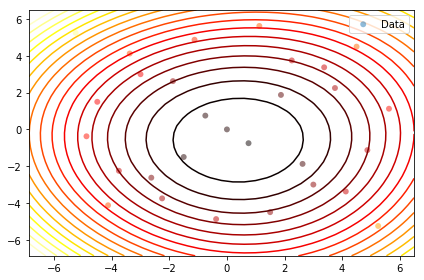

 /usr/local/lib/python3.5/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


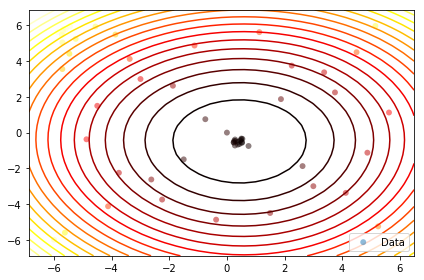

In [18]:
# 11. plot GPs approximation
# plot the model trained on 30 points
model = GPy.models.GPRegression(Q_30, E_30, GPy.kern.RBF(2)+GPy.kern.White(2))
model.optimize()
model.plot()
plt.show()

# plot the model trained on 60 points
model.set_XY(Q, E)
model.optimize()
model.plot()
plt.show()

In order for this method to work f(x,y) must be continuous.

## 2) Reconstruction of a Corrupted Image
For code have a look at ridge-regressoin.py here we will only provide the plots and the answers to the questions.

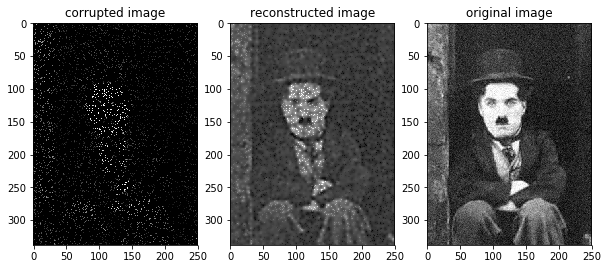

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(10,6))
axes[0].imshow(plt.imread("cc_90.png"), cmap="gray")
axes[0].set_title("corrupted image")
axes[1].imshow(plt.imread("res.png"), cmap="gray")
axes[1].set_title("reconstructed image")
axes[2].imshow(plt.imread("charlie-chaplin.jpg"), cmap="gray")
axes[2].set_title("original image")
plt.show()

The inverse is computed by using conjugate gradient iteration. This solves the equation $(K + \tau*1\!\!1)D = y$ for D

All computations are made with a sparse datastructure which is a good choice because many entries of the Kernel matrix are zero.

## 3) Bayesian Optimization of Hyperparameters

In [52]:
# 1. implement COR calculation
def COR(A, B):
    mean_A = np.mean(A)
    mean_B = np.mean(B)
    return (np.sum((A - mean_A) * (B - mean_B))) / (np.sqrt(np.sum((A - mean_A)**2)) * np.sqrt(np.sum((B - mean_B)**2)))

In [56]:
# 2. Adapt solution from task 1
original_image = plt.imread("charlie-chaplin.jpg")

number_of_samples = 30
hyperparams = np.zeros((number_of_samples, 3))
corr_coeff = np.zeros((number_of_samples, 1))
for i in range(number_of_samples):
    tau, rho, gamma = sobol.i4_sobol(3, i)[0]
    tau = tau * (1 - 0.005) + 0.005
    rho = rho * (7 - 1) + 1
    gamma = gamma * (4 - 1) + 1
    hyperparams[i] = [tau, rho, gamma]
    reconstructed_image = kernel_ridge_regression(tau, 2, rho, gamma)
    corr_coeff[i] = COR(reconstructed_image, original_image)


gp2 = GPy.models.GPRegression(hyperparams, corr_coeff, GPy.kern.Matern52(3))
gp2.optimize()

def utility_function(tau, rho, gamma):
    return gp2.posterior_samples(np.array([[tau, rho, gamma]]), size=1)[0][0]

for i in range(30):
    params, details, _ = optunity.maximize(utility_function, num_evals=100, tau=[0.005, 1], rho=[1, 7], gamma=[1, 4], solver_name='particle swarm')
    reconstructed_image = kernel_ridge_regression(params['tau'], 2, params['rho'], params['gamma'])
    corr = COR(reconstructed_image, original_image)
    hyperparams_new = np.zeros(((hyperparams.shape[0] + 1), 3))
    hyperparams_new[range(hyperparams.shape[0])] = hyperparams
    hyperparams_new[-1] = np.array([params['tau'], params['rho'], params['gamma']])
    hyperparams = hyperparams_new
    corr_coeff_new = np.zeros(((corr_coeff.shape[0] + 1), 1))
    corr_coeff_new[range(corr_coeff.shape[0])] = corr_coeff
    corr_coeff_new[-1] = [corr]
    corr_coeff = corr_coeff_new
    gp2.set_XY(hyperparams, corr_coeff)
    gp2.optimize()

training...
building input kernel matrix
sparsity: 0.237
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 5.416 seconds.
(338, 250)
training...
building input kernel matrix
sparsity: 0.309
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 11.277 seconds.
(338, 250)
training...
building input kernel matrix
sparsity: 0.091
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 11.576 seconds.
(338, 250)
training...
building input kernel matrix
sparsity: 1.166
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 11.316 seconds.
(338, 250)
training...
building input kernel matrix
sparsity: 0.169
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 11.059 seconds.
(338, 250)
training...
building input kern

done predicting
Train and predict took 11.332 seconds.
(338, 250)
training...
building input kernel matrix
sparsity: 3.537
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 12.011 seconds.
(338, 250)
training...
building input kernel matrix
sparsity: 0.300
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 13.117 seconds.
(338, 250)
training...
building input kernel matrix
sparsity: 0.382
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 11.303 seconds.
(338, 250)
training...
building input kernel matrix
sparsity: 0.169
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 12.129 seconds.
(338, 250)
training...
building input kernel matrix
sparsity: 0.214
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and pred

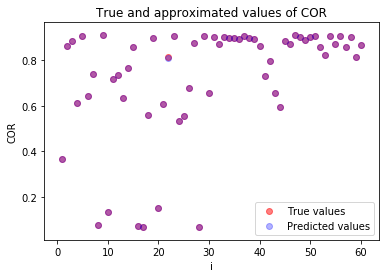

In [67]:
# 3. plot true and approximated values of COR
predicted_values = []
for i in range(len(hyperparams)):
    predicted_values.append(gp2.posterior_samples(np.array([hyperparams[i]]), size=1)[0][0])
predicted_values = np.asarray(predicted_values)

i = np.arange(1, 61)
plt.scatter(i, corr_coeff, c='r', label='True values', alpha=0.5)
plt.scatter(i, predicted_values, c='b', label='Predicted values', alpha=0.3)
plt.xlabel('i')
plt.ylabel('COR')
plt.title('True and approximated values of COR')
plt.legend()
plt.show()

In [68]:
# reconstruct image using best hyperparameter
best_params = hyperparams[np.argmax(corr_coeff)]
best_reconstruction = kernel_ridge_regression(best_params[0], 2, best_params[1],  best_params[2])

training...
building input kernel matrix
sparsity: 0.264
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 11.290 seconds.
(338, 250)


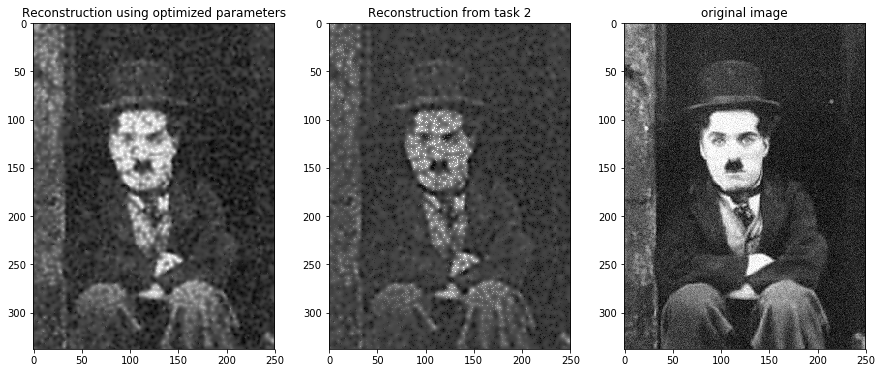

In [70]:
# 4. plot it
fig, axes = plt.subplots(1, 3, figsize=(15,6))
axes[0].imshow(best_reconstruction, cmap="gray")
axes[0].set_title("Reconstruction using optimized parameters")
axes[1].imshow(plt.imread("res.png"), cmap="gray")
axes[1].set_title("Reconstruction from task 2")
axes[2].imshow(plt.imread("charlie-chaplin.jpg"), cmap="gray")
axes[2].set_title("original image")
plt.show()

The reconstruction using the optimized hyperparameters is better than the reconstruction from task 2. As expected since we searched for the best parameters.